In [9]:
import torch
import torch.nn.functional as F

In [10]:
H = 4
W = 8

img_dense = (torch.rand((1, 1, 4, 4)) > 0.5).float()
img_dense = torch.tensor([
    [1,0,0,0,0,0,1,0],
    [1,1,1,1,1,1,1,1],
    [0,0,0,1,1,0,0,0],
    [0,1,0,1,0,0,0,1],
],dtype=float).view(1, 1, H, W)
img = img_dense.view(1, H, W).to_sparse_coo()
img_dense

tensor([[[[1., 0., 0., 0., 0., 0., 1., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 0., 0., 0.],
          [0., 1., 0., 1., 0., 0., 0., 1.]]]], dtype=torch.float64)

In [11]:
scale = 1.75

img_resized_dense = F.interpolate(img_dense, size=(H, round(W*scale)), mode='nearest')
img_resized_sparse = img_resized_dense.view(1, H, round(W*scale)).to_sparse_coo()
img_resized_dense

tensor([[[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]]]],
       dtype=torch.float64)

In [12]:
img.indices(), img_resized_sparse.indices()

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3],
         [0, 6, 0, 1, 2, 3, 4, 5, 6, 7, 3, 4, 1, 3, 7]]),
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
           2,  2,  2,  3,  3,  3,  3],
         [ 0,  1, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
           6,  7,  8,  2,  3,  6, 13]]))

In [13]:
import math

truth = img_resized_sparse.indices()[2]

idx = F.interpolate((img.indices()).float().view(1, 1, 3, img._nnz()), size=(3, round(img._nnz()*scale)), mode='nearest').view(3, round(img._nnz()*scale))
print(idx[2]*scale)
idx[2] = torch.round(idx[2]*scale - 1e-4)

t = (idx == torch.roll(idx, 1, -1)).float().cumprod(0)[-1]
t_cs = t.cumsum(0)
t_offset = t_cs - (t_cs * (1-t)).cummax(0)[0]
idx[2] = torch.round(idx[2] + t_offset + 1e-6)
def saddle(idx, depth=2):
    if depth == 0: return idx
    t = (idx == torch.roll(idx, 1, -1)).float().cumprod(0)[-1]
    t_cs = t.cumsum(0)
    t_offset = t_cs - (t_cs * (1-t)).cummax(0)[0]
    idx[2] = torch.round(idx[2] + t_offset)
    return saddle(idx, depth-1)
# idx = saddle(idx, math.ceil(scale) + 2)

print('interp', idx[2], 'truth', truth.float(), sep='\n')
print('-')
print(img_resized_sparse.indices().float(), idx, sep='\n')

tensor([ 0.0000,  0.0000, 10.5000, 10.5000,  0.0000,  0.0000,  1.7500,  3.5000,
         3.5000,  5.2500,  5.2500,  7.0000,  7.0000,  8.7500, 10.5000, 10.5000,
        12.2500, 12.2500,  5.2500,  5.2500,  7.0000,  1.7500,  1.7500,  5.2500,
         5.2500, 12.2500])
interp
tensor([ 0.,  1., 10., 11.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10., 11., 12., 13.,  5.,  6.,  7.,  2.,  3.,  5.,  6., 12.])
truth
tensor([ 0.,  1., 11., 12.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10., 11., 12., 13.,  6.,  7.,  8.,  2.,  3.,  6., 13.])
-
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.],
        [ 0.,  1., 11., 12.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
         10., 11., 12., 13.,  6.,  7.,  8.,  2.,  3.,  6., 13.

In [14]:
img = (torch.rand((1, 3, 3)) > 0.5).float()

In [16]:
def resize_width(img: torch.Tensor, scale: float):
    assert img.is_sparse
    N, H, W = img.shape
    idx = img.indices().float()
    ndim, nnz = idx.shape
    assert ndim == 3
    idx = F.interpolate(idx.float().view(1, 1, ndim, nnz), size=(ndim, round(nnz*scale)),mode='nearest').view(ndim, -1)
    idx[2] = idx[2]*scale
    t = (idx == torch.roll(idx, 1, -1)).float().cumprod(0)[-1]
    t_cs = t.cumsum(0)
    t_offset = t_cs - (t_cs * (1-t)).cummax(0)[0]
    idx[2] = torch.round(idx[2] + t_offset + 1e-6)
    def saddle(idx, depth):
        if depth == 0: return idx
        t = (idx == torch.roll(idx, 1, -1)).float().cumprod(0)[-1]
        t_cs = t.cumsum(0)
        t_offset = t_cs - (t_cs * (1-t)).cummax(0)[0]
        idx[2] = torch.round(idx[2] + t_offset)
        return saddle(idx, depth-1)
    idx = saddle(idx, math.ceil(scale))

    idx[2] = torch.clamp(idx[2] + t_offset, 0, round(W*scale)-1)
    idx = torch.floor(idx).long()
    idx = torch.unique(idx, dim=-1)
    print(idx)
    return torch.sparse_coo_tensor(
        indices=idx, 
        values=torch.ones((idx.shape[-1],), device=img.device, dtype=img.dtype),
        size=(img.shape[0], img.shape[1], round(img.shape[2] * scale))
    )

img_sparse = img.to_sparse_coo()
print(img_sparse.indices())
scale = 1.5
resized_sparse = resize_width(img_sparse, scale).coalesce()
resized_truth = F.interpolate(img.unsqueeze(0), (3, round(scale*3)), mode='nearest').squeeze(0)
resized_truth_sparse = resized_truth.to_sparse_coo()

print('indices:')
print(resized_sparse.indices(), resized_truth_sparse.indices(), sep='\n')
print('-')
img, resized_sparse.to_dense(), resized_truth

tensor([[0, 0, 0, 0],
        [0, 1, 2, 2],
        [2, 1, 0, 1]])
tensor([[0, 0, 0, 0],
        [0, 1, 2, 2],
        [3, 2, 0, 2]])
indices:
tensor([[0, 0, 0, 0],
        [0, 1, 2, 2],
        [3, 2, 0, 2]])
tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 2, 2],
        [3, 2, 0, 1, 2]])
-


(tensor([[[0., 0., 1.],
          [0., 1., 0.],
          [1., 1., 0.]]]),
 tensor([[[0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [1., 0., 1., 0.]]]),
 tensor([[[0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [1., 1., 1., 0.]]]))

In [17]:
import math
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

/home/ainl/anaconda3/envs/torch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


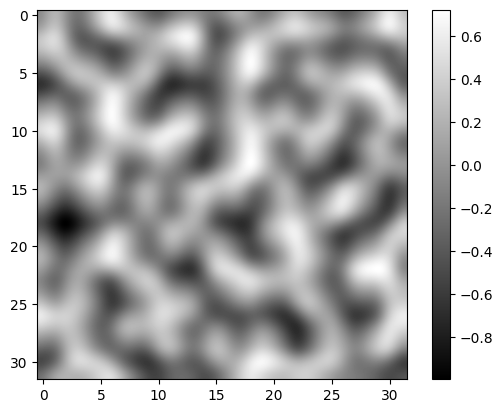

In [18]:
import matplotlib.pyplot as plt
noise = rand_perlin_2d((32, 32), (8, 8))
plt.clf()
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()

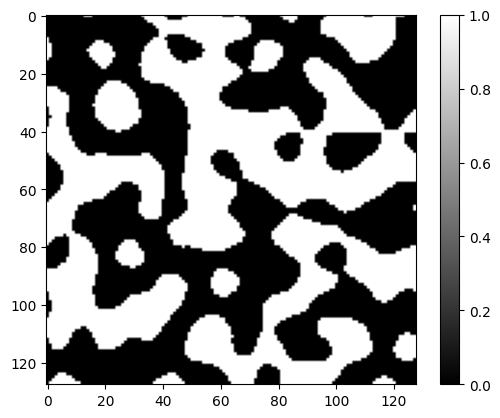

tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ..., 127, 127, 127],
        [ 20,  22,  23,  ..., 176, 178, 181]])


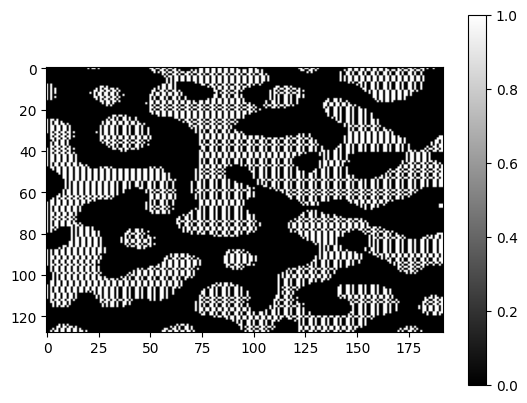

In [19]:
noise = (rand_perlin_2d((128, 128), (8, 8)) > 0).float()
plt.clf()
plt.imshow(noise, cmap='gray')
plt.colorbar()
plt.show()

resized = resize_width(noise.view(1, 128, 128).to_sparse_coo(), 1.5).coalesce().to_dense()[0]
plt.clf()
plt.imshow(resized, cmap='gray')
plt.colorbar()
plt.show()

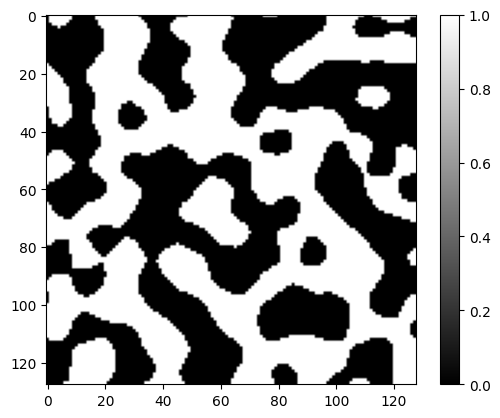

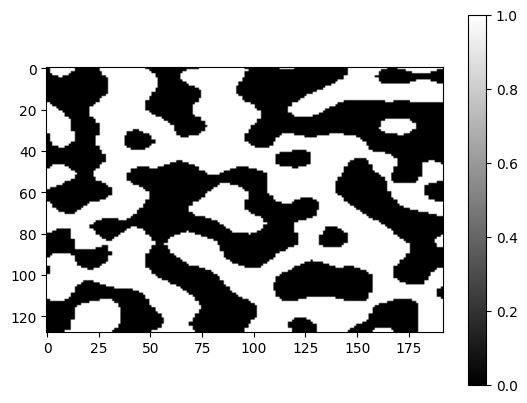

In [57]:
import math
def resize_width(img: torch.Tensor, scale: float):
    N, H, W = img.shape
    img = img.coalesce()
    idx = img.indices().float()
    nnz = idx.shape[-1]
    if scale < 1.0:
        xs_scaled = idx[2] * scale
        xs_rounded = torch.clamp(torch.round(xs_scaled), 0, round(W*scale)-1)
        xs_okay = torch.abs(xs_rounded - xs_scaled) < (scale * 0.5)
        idx[2] = xs_rounded * xs_okay
        idx = idx * xs_okay.unsqueeze(0) + (~xs_okay.unsqueeze(0)) * -1
        idx = torch.unique(idx.long(), dim=-1)
        idx = idx[:, 1:]
        
        # print(nnz, idx.shape[-1])
        return torch.sparse_coo_tensor(
            indices=idx,
            values=torch.ones((idx.shape[-1],), device=img.device, dtype=img.dtype),
            size=(N, H, round(W*scale)),
        )
    elif scale > 1.0:
        scale_ceil = math.ceil(scale)
        idx = F.interpolate(idx.view(1, 1, 3, nnz), size=(3, nnz*scale_ceil), mode='nearest').view(3, nnz*scale_ceil)
        idx[2] = idx[2] * scale_ceil + torch.arange(nnz*scale_ceil) % scale_ceil
        
        shrink_scale = scale / scale_ceil
        xs_scaled = idx[2] * shrink_scale
        xs_rounded = torch.round(xs_scaled)
        xs_okay = torch.abs(xs_rounded - xs_scaled) < (shrink_scale * 0.5)
        idx[2] = xs_rounded * xs_okay
        idx = idx * xs_okay.unsqueeze(0) + (~xs_okay.unsqueeze(0)) * -1
        idx = torch.unique(idx.long(), dim=-1)
        idx = idx[:, 1:]
        idx[2] = torch.clamp(idx[2], 0, round(W*scale)-1)
        idx = torch.unique(idx.long(), dim=-1)
        
        # print(nnz, idx.shape[-1])
        return torch.sparse_coo_tensor(
            indices=idx,
            values=torch.ones((idx.shape[-1],), device=img.device, dtype=img.dtype),
            size=(N, H, round(W*scale)),
        )
    else:
        return img

noise = (rand_perlin_2d((128, 128), (8, 8)) > 0).float()
# noise = (torch.rand((128, 128)) > 0.5).float()
plt.clf()
plt.imshow(noise, cmap='gray')
plt.colorbar()
plt.show()

resized = resize_width(noise.view(1, 128, 128).to_sparse_coo(), 1.5).coalesce().to_dense()[0]
plt.clf()
plt.imshow(resized, cmap='gray')
plt.colorbar()
plt.show()

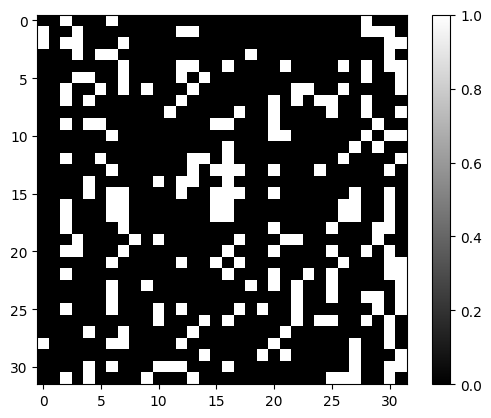

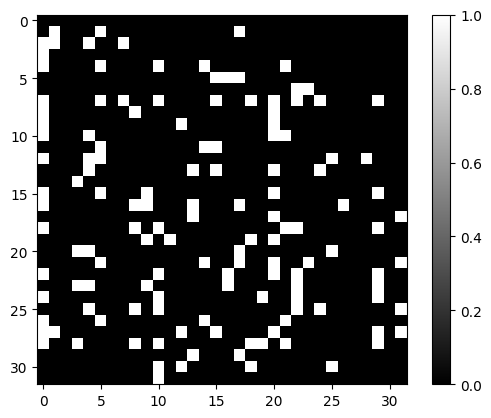

In [60]:
state = torch.load('help.pth', map_location='cpu')
def imshow(t:torch.Tensor):
    x = t.cpu().numpy()
    plt.clf()
    plt.imshow(x, cmap='gray')
    plt.colorbar()
    plt.show()
imshow(state['a'].to_dense()[1])
imshow(state['b'].to_dense()[1])
# imshow(resize_width(state['b'], 32/128).to_dense()[1])